In [1]:
# transformer_testing.py
import os, sys, json
import joblib
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score
import logging
import matplotlib.pyplot as plt
from config.settings import *

logging.basicConfig(level=logging.INFO, format='%(message)s')

# ---------------------------------------------------------------------
# Paths / config
# ---------------------------------------------------------------------
PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"

from multiomic_transformer.models.model import MultiomicTransformer
from multiomic_transformer.datasets.dataset import MultiomicTransformerDataset

experiment = "model_training_001"
SELECTED_EXPERIMENT_DIR = OUTPUT_DIR / CHROM_ID / experiment

GROUND_TRUTH_DIR = os.path.join(PROJECT_DIR, "data/ground_truth_files")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH  = 32
TG_CHUNK = 64

In [ ]:
moods_df = pd.read_csv(os.path.join(TRAINING_DATA_CACHE, f"{CHROM_ID}_moods_sites.tsv"), sep="\t")
moods_df.head()

In [2]:
beeline_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "mESC_beeline_ChIP-seq.csv"))
beeline_ground_truth = beeline_ground_truth.rename(columns={"Gene1":"TF", "Gene2":"TG"})

In [3]:
orti_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "ORTI_ground_truth_TF_TG.csv"))
orti_ground_truth = orti_ground_truth.rename(columns={"Gene1":"TF", "Gene2":"TG"})

In [8]:
rn112_ground_truth = pd.read_csv(
    "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN112_LOGOF_BEELINE_Mouse_ESC.tsv",
    sep="\t"
)
rn112_ground_truth = rn112_ground_truth.rename(columns={"Source":"TF", "Target":"TG"})
rn112_ground_truth = rn112_ground_truth[["TF", "TG"]]

In [7]:
rn114_ground_truth = pd.read_csv(
    "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN114_ChIPX_ESCAPE_Mouse_ESC.tsv",
    sep="\t"
)
rn114_ground_truth = rn114_ground_truth.rename(columns={"Source":"TF", "Target":"TG"})
rn114_ground_truth = rn114_ground_truth[["TF", "TG"]]

In [4]:
rn115_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "rn115_chipseq.tsv"), sep="\t")
rn115_ground_truth = rn115_ground_truth.rename(columns={"sourceName":"TF", "targetName":"TG"})
rn115_ground_truth = rn115_ground_truth[["TF", "TG"]]

In [6]:
chip_atlas_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "chip_atlas_tf_peak_tg_dist.csv"), header=0, index_col=None)
chip_atlas_ground_truth = chip_atlas_ground_truth.loc[chip_atlas_ground_truth.groupby(["source_id", "peak_id"])["distance"].idxmin()]
chip_atlas_ground_truth = chip_atlas_ground_truth[["source_id", "target_id"]].drop_duplicates()
chip_atlas_ground_truth = chip_atlas_ground_truth.rename(columns={"source_id":"TF", "target_id":"TG"})

In [5]:
rn117_ground_truth = pd.read_csv(os.path.join(GROUND_TRUTH_DIR, "RN117.tsv"), sep="\t", header=0, index_col=None)
rn117_ground_truth = rn117_ground_truth[["Source", "Target"]].drop_duplicates()
rn117_ground_truth = rn117_ground_truth.rename(columns={"Source":"TF", "Target":"TG"})
rn117_ground_truth.head()


,TF,TG
0,ARID3A,A4GALT
1,ARID3A,AAAS
2,ARID3A,AADACL2-AS1
3,ARID3A,AADACL2
4,ARID3A,AADACL4


In [29]:
# beeline_ground_truth, 
# rn112_ground_truth,
# rn114_ground_truth,
# rn115_ground_truth, 

combined_ground_truth = pd.concat([
        orti_ground_truth, 
        chip_atlas_ground_truth,
        rn117_ground_truth
    ]).drop_duplicates(subset=["TF", "TG"])
combined_ground_truth["TF"] = combined_ground_truth["TF"].str.capitalize()
combined_ground_truth["TG"] = combined_ground_truth["TG"].str.capitalize()
combined_ground_truth = combined_ground_truth.drop_duplicates(subset=["TF", "TG"])
combined_ground_truth.to_csv(os.path.join(GROUND_TRUTH_DIR, "combined_ground_truth.csv"), index=None, header=True)

In [10]:
combined_ground_truth.head()

,TF,TG
0,Acp1,Hba-a1
1,Acp2,Hba-a1
2,Ap1,Clu
3,Ap1,Fabp4
4,Ap1,Mbp


In [11]:
combined_ground_truth.shape

(2123263, 2)

In [12]:
rn111_and_rn112 = pd.concat([beeline_ground_truth, rn112_ground_truth])
rn111_and_rn112["TF"] = rn111_and_rn112["TF"].str.capitalize()
rn111_and_rn112["TG"] = rn111_and_rn112["TG"].str.capitalize()
rn111_and_rn112 = rn111_and_rn112.drop_duplicates()
rn111_and_rn112.head()

,TF,TG
0,Adnp,Mis18bp1
1,Adnp,Exd1
2,Adnp,Chp1
3,Adnp,Oscar
4,Adnp,Ndufa3


In [17]:
num_rn111_and_rn112_edges = rn111_and_rn112.shape[0]
print(f"Number of RN111 and RN112 Edges: {num_rn111_and_rn112_edges:,}")

Number of RN111 and RN112 Edges: 1,064,578


In [ ]:
rn111_and_rn112_overlap_with_combined = pd.merge(rn111_and_rn112, combined_ground_truth, on=["TF", "TG"], how="outer", indicator=True)
rn111_and_rn112_overlap_with_combined.head()

print(f"Number of edges only in RN111 and RN112: {len(rn111_and_rn112_overlap_with_combined[rn111_and_rn112_overlap_with_combined['_merge'] == 'left_only'])}")
print(f"Number of edges only in Combined GT: {len(rn111_and_rn112_overlap_with_combined[rn111_and_rn112_overlap_with_combined['_merge'] == 'right_only'])}")
print(f"Number of edges in both ground truths: {len(rn111_and_rn112_overlap_with_combined[rn111_and_rn112_overlap_with_combined['_merge'] == 'both'])}")

Number of edges only in RN111 and RN112: 928365
Number of edges only in Combined GT: 1987050
Number of edges in both ground truths: 136213


In [30]:
combined_ground_truth_unique_edges = rn111_and_rn112_overlap_with_combined[rn111_and_rn112_overlap_with_combined['_merge'] == 'right_only']
combined_ground_truth_unique_edges = combined_ground_truth_unique_edges[["TF", "TG"]].dropna()
combined_ground_truth_unique_edges.to_csv(os.path.join(GROUND_TRUTH_DIR, "combined_ground_truth_no_rn111_or_rn112_edges.csv"), index=None, header=True)

num_tfs = combined_ground_truth_unique_edges["TF"].nunique()
num_tgs = combined_ground_truth_unique_edges["TG"].nunique()

print(f"Num TFs = {num_tfs:,}")
print(f"Num TGs = {num_tgs:,}")
print(f"Num Edges = {combined_ground_truth_unique_edges.shape[0]:,}")

Num TFs = 488
Num TGs = 36,459
Num Edges = 1,986,908


In [5]:
gene_near_peaks_df = pd.read_parquet(os.path.join(SAMPLE_DATA_CACHE_DIR, CHROM_ID, f"genes_near_peaks_{CHROM_ID}.parquet"))
training_log_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "training_log.csv"), header=0)
gradient_attribution_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "test_results/gradient_attribution.csv"), index_col=0)
shortcut_matrix_df = pd.read_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "test_results/shortcut_matrix.csv"), index_col=0)

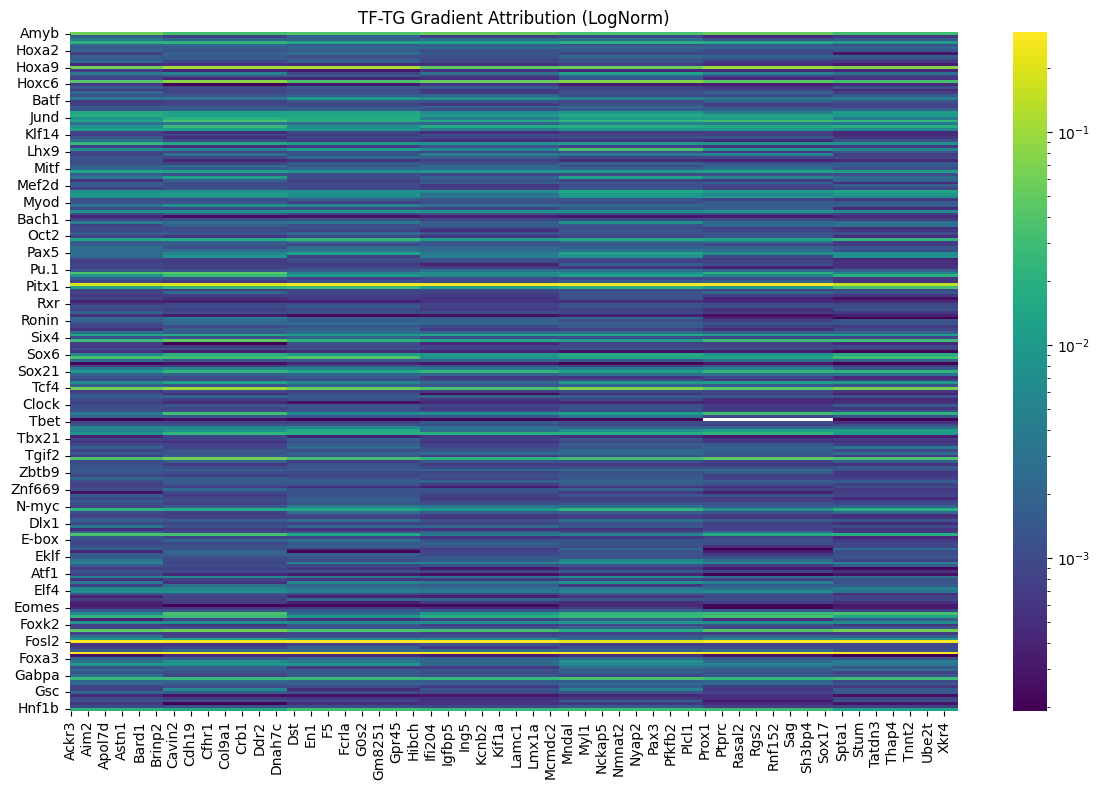

In [8]:
import seaborn as sns
from matplotlib.colors import LogNorm

df_subset = gradient_attribution_df.loc[
    [idx for idx in gradient_attribution_df.index if len(str(idx)) < 7],      # row filter
    [col for col in gradient_attribution_df.columns if len(str(col)) < 7]    # column filter
]

data = df_subset.iloc[:100, :100].copy()
vmin = max(1e-9, float(data[data > 0].min().min()))
vmax = float(data.max().max())

plt.figure(figsize=(12,8))
sns.heatmap(df_subset, cmap="viridis", norm=LogNorm(vmin=vmin, vmax=vmax))
plt.title("TF-TG Gradient Attribution (LogNorm)")
plt.tight_layout()
plt.show()

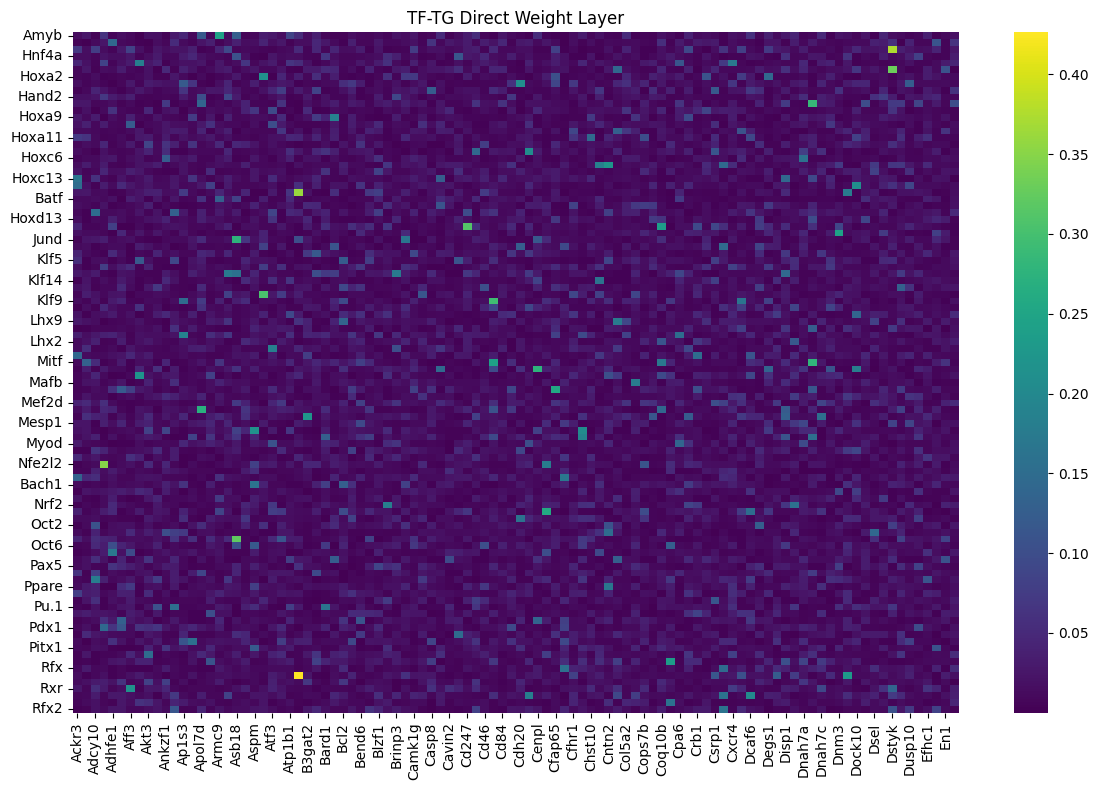

In [7]:
import seaborn as sns

df_subset = shortcut_matrix_df.loc[
    [idx for idx in shortcut_matrix_df.index if len(str(idx)) < 7],      # row filter
    [col for col in shortcut_matrix_df.columns if len(str(col)) < 7]    # column filter
]
plt.figure(figsize=(12,8))
sns.heatmap(df_subset.iloc[:100, :100], cmap="viridis")
plt.title("TF-TG Direct Weight Layer")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import pearsonr
def plot_per_gene_correlation_scatterplot(model, dataloader, gpu_id=0, outpath=None):
    model.eval()
    preds, tgts = [], []
    with torch.no_grad():
        for atac_wins, tf_tensor, targets, bias in dataloader:
            atac_wins, tf_tensor, targets, bias = (
                atac_wins.to(gpu_id),
                tf_tensor.to(gpu_id),
                targets.to(gpu_id),
                bias.to(gpu_id)
            )
            output = model(atac_wins, tf_tensor)
            preds.append(output.cpu().numpy())
            tgts.append(targets.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    tgts  = np.concatenate(tgts, axis=0)

    # inverse-transform
    # preds_rescaled = scaler.inverse_transform(preds)
    # tgts_rescaled  = scaler.inverse_transform(tgts)
    preds_rescaled = preds
    tgts_rescaled  = tgts

    corr, _ = pearsonr(preds_rescaled.ravel(), tgts_rescaled.ravel())
    print(f"Test Pearson correlation: {corr:.3f}")

    plt.figure(figsize=(6,6))
    plt.scatter(tgts_rescaled, preds_rescaled, alpha=0.5, s=5)
    plt.xlabel("True values")
    plt.ylabel("Predicted values")
    plt.title(f"Predicted vs True (r={corr:.3f})")
    plt.plot([tgts_rescaled.min(), tgts_rescaled.max()],
             [tgts_rescaled.min(), tgts_rescaled.max()], 'r--')
    if outpath:
        plt.savefig(outpath, dpi=300)
    else:
        plt.show()
        

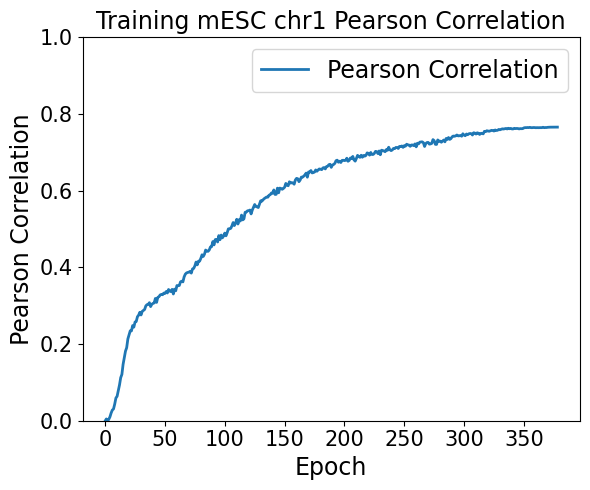

In [13]:
def plot_pearson_corr_across_epochs(df, dataset_name, chrom_id):
    fig = plt.figure(figsize=(6, 5))
    plt.plot(df.index, df["Pearson"], linewidth=2, label="Pearson Correlation")

    plt.title(f"Training {dataset_name} {chrom_id} Pearson Correlation", fontsize=17)
    plt.ylim((0,1))
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlabel("Epoch", fontsize=17)
    plt.ylabel("Pearson Correlation", fontsize=17)
    plt.legend(fontsize=17)
    plt.tight_layout()
    
    return fig

fig = plot_pearson_corr_across_epochs(training_log_df, "mESC", "chr1")
fig.savefig(os.path.join(SELECTED_EXPERIMENT_DIR, "eval_results_pearson_corr.png"), dpi=300)
fig.show()

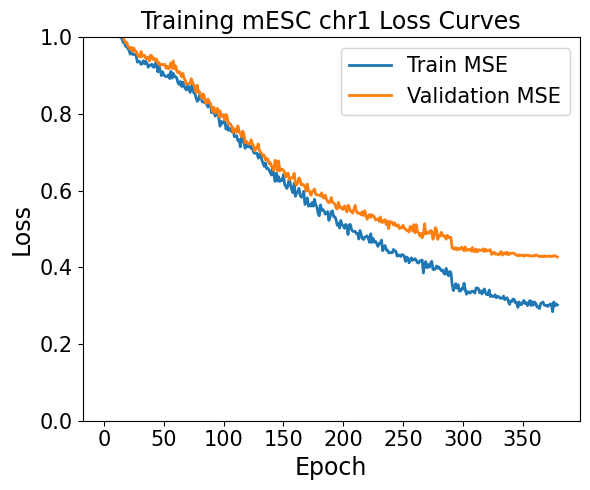

In [14]:
def plot_train_val_loss(df, dataset_name, chrom_id):
    fig = plt.figure(figsize=(6, 5))
    plt.plot(df["Epoch"], df["Train MSE"], label="Train MSE", linewidth=2)
    plt.plot(df["Epoch"], df["Val MSE"], label="Validation MSE", linewidth=2)
    # plt.plot(df["Epoch"], df["Train Total Loss"], label="Train Total Loss", linestyle="--", alpha=0.7)

    plt.title(f"Training {dataset_name} {chrom_id} Loss Curves", fontsize=17)
    plt.xlabel("Epoch", fontsize=17)
    plt.ylabel("Loss", fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim([0, 1])
    plt.legend(fontsize=15)
    plt.tight_layout()
    return fig
    
fig = plot_train_val_loss(training_log_df, "mESC", "chr1")
fig.savefig(os.path.join(SELECTED_EXPERIMENT_DIR, "eval_results_training_loss.png"), dpi=300)
fig.show()

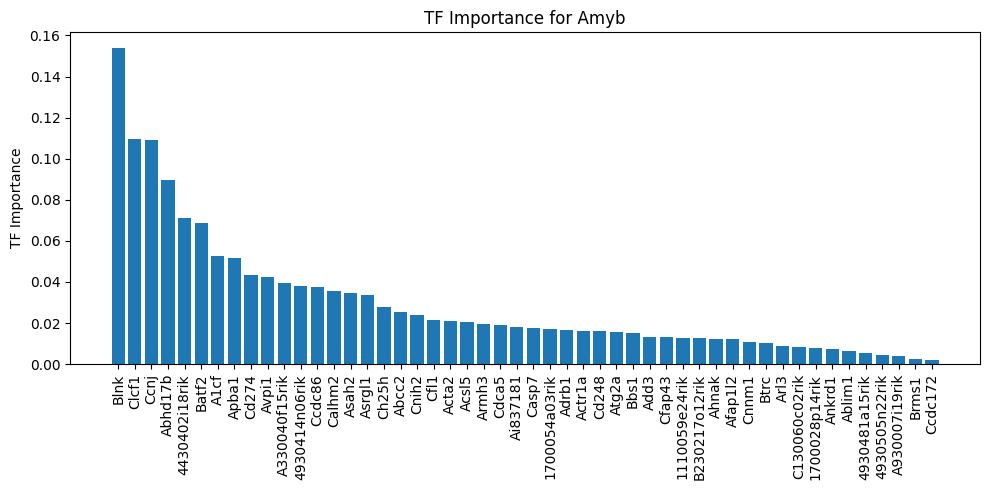

In [21]:
tf_imp_dir = os.path.join(SELECTED_EXPERIMENT_DIR, "test_results")
            
tf_importance_df = pd.read_csv(os.path.join(tf_imp_dir, "shortcut_matrix.csv"), header=0, index_col=0)

fig = plt.figure(figsize=(10,5))

selected_tg = tf_importance_df.index[0]
selected_tf_row = tf_importance_df.iloc[0]
selected_tf_row = selected_tf_row.iloc[:50].sort_values(ascending=False)

plt.xticks(rotation=90, fontsize=10)
plt.bar(x=selected_tf_row.index, height=selected_tf_row)
plt.title(f"TF Importance for {selected_tg}")
plt.ylabel("TF Importance")
plt.tight_layout()
plt.show()

In [30]:
from grn_inference.utils import minmax_norm_col

In [31]:
edges_df = (
    tf_importance_df
    .reset_index()
    .melt(id_vars="index", var_name="Target", value_name="score")
    .rename(columns={"index": "Source"})
)

print(edges_df.head())
edges_df["score"] = minmax_norm_col(edges_df["score"])
edges_df.to_csv(os.path.join(SELECTED_EXPERIMENT_DIR, "inferred_grn.csv"), header=True, index=False)

  Source         Target     score
0   Amyb  1110059e24rik  0.012926
1   Ap-1  1110059e24rik  0.007593
2  Atoh1  1110059e24rik  0.002979
3  Hnf4a  1110059e24rik  0.016630
4   Hnf6  1110059e24rik  0.059909


In [ ]:
tf_importance_df.melt()

,1110059e24rik,1700028p14rik,1700054a03rik,4430402i18rik,4930414n06rik,4930481a15rik,4930505n22rik,A1cf,A330040f15rik,A930007i19rik,...,Trpt1,Tsga10ip,Unc93b1,Vldlr,Vps13a,Vti1a,Vwa2,Wnt8b,Yif1a,Zfand5
Amyb,0.012926,0.007979,0.016949,0.071295,0.038051,0.005369,0.004322,0.052676,0.039596,0.004102,...,0.021498,0.008520,0.030714,0.005480,0.018128,0.010033,0.005197,0.023149,0.054277,0.013118
Ap-1,0.007593,0.016408,0.060694,0.075351,0.003203,0.018191,0.025439,0.010395,0.014900,0.006479,...,0.005965,0.112763,0.024329,0.004895,0.008635,0.009053,0.069101,0.052359,0.032719,0.007553
Atoh1,0.002979,0.008848,0.006363,0.017177,0.027394,0.096839,0.007401,0.006691,0.040941,0.011984,...,0.007331,0.024119,0.021316,0.077002,0.085251,0.058651,0.088675,0.007731,0.019807,0.007677
Hnf4a,0.016630,0.025051,0.012493,0.036420,0.022744,0.012015,0.047341,0.020354,0.005996,0.003615,...,0.006587,0.020681,0.005124,0.049497,0.018169,0.001901,0.020302,0.002485,0.004840,0.071207
Hnf6,0.059909,0.013033,0.030434,0.009828,0.022351,0.014792,0.024875,0.005045,0.006072,0.004852,...,0.052047,0.005143,0.016318,0.004523,0.032682,0.002094,0.002916,0.013019,0.024267,0.088734


In [26]:
def evaluate_chip_aucs(tf_importance_df, chip_df, k_list=(100, 500, 1000, 5000)):
    """
    Evaluate AUROC / PR-AUC / Precision K against CHIP edges.
    We uppercase both the CHIP and the DF indexing to align.
    """
    chip_edges = {(t.upper(), g.upper()) for t, g in zip(chip_df["TF"], chip_df["TG"])}

    # Uppercase DF indexing for matching
    tf_imp = tf_importance_df.copy()
    tf_imp.index   = [x.upper() for x in tf_imp.index]
    tf_imp.columns = [x.upper() for x in tf_imp.columns]

    rn111_tfs = {t for t, _ in chip_edges}
    rn111_tgs = {g for _, g in chip_edges}

    tf_imp = tf_imp.loc[tf_imp.index.intersection(rn111_tfs),
                        tf_imp.columns.intersection(rn111_tgs)]
    if tf_imp.empty:
        raise ValueError("No overlap between TF/TG names and CHIP set.")

    scores, labels, edges = [], [], []
    # Flatten
    for tg in tf_imp.columns:
        col = tf_imp[tg]
        for tf, score in col.items():
            scores.append(float(score))
            labels.append(1 if (tf, tg) in chip_edges else 0)
            edges.append((tf, tg))

    if len(set(labels)) < 2:
        raise ValueError("Only one class present after overlap; AUROC/PR-AUC undefined.")

    auroc = roc_auc_score(labels, scores)
    auprc = average_precision_score(labels, scores)

    # Precision K
    df_scored = pd.DataFrame(edges, columns=["tf", "tg"])
    df_scored["score"] = scores
    df_scored["label"] = labels
    df_scored = df_scored.sort_values("score", ascending=False).reset_index(drop=True)

    results = {"AUROC": auroc, "PR-AUC": auprc, "positives": int(sum(labels)), "edges": int(len(labels))}
    for k in k_list:
        k = int(k)
        if k <= len(df_scored):
            prec_k = df_scored.head(k)["label"].mean()
            results[f"Precision@{k}"] = float(prec_k)

    return results, df_scored

results, df_scored = evaluate_chip_aucs(tf_importance_df, rn115_ground_truth, k_list=(100, 500, 1000, 5000))

print(f"AUROC = {results['AUROC']:.4f}  |  PR-AUC = {results['PR-AUC']:.4f}  "
        f"| positives={results['positives']} / {results['edges']} edges")
for k in (100, 500, 1000, 5000):
    key = f"AUROC@{k}"
    if key in results:
        print(f"{key}: {results[key]:.3f}")


AUROC = 0.5003  |  PR-AUC = 0.1710  | positives=397 / 2544 edges


In [ ]:
import torch
training_data_cache = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/data/training_data_cache/mESC"

total_moods_site_df_list = []
peak_gene_dist_df_list = []

for subdir in os.listdir(training_data_cache):
    if "chr" in subdir:
        chr_path = os.path.join(training_data_cache, subdir)
        
        moods_path = os.path.join(chr_path, f"moods_sites_{subdir}.tsv")
        peak_gene_dist = os.path.join(chr_path, f"genes_near_peaks_{subdir}.parquet")
        
        if os.path.isfile(moods_path):
            chr_moods_sites_df = pd.read_csv(moods_path, sep="\t")
            total_moods_site_df_list.append(chr_moods_sites_df)
            
        if os.path.isfile(peak_gene_dist):
            chr_peak_gene_dist_df = pd.read_parquet(peak_gene_dist, engine="pyarrow")
            peak_gene_dist_df_list.append(chr_peak_gene_dist_df)

total_moods_sites = pd.concat(total_moods_site_df_list)
total_peak_gene_dist = pd.concat(peak_gene_dist_df_list)


In [37]:
print("Moods DataFrame")
print(total_moods_sites.head())
print()
print("peak-gene distance dataframe")
print(total_peak_gene_dist.head())

Moods DataFrame
                    peak_id         TF    pos   logodds strand
0  chr5:100004870-100005470  At3g46070  285.0  4.201540      -
1  chr5:100007878-100008478  At3g46070  162.0  4.902650      -
2  chr5:100039792-100040392  At3g46070  559.0  3.333572      -
3  chr5:100047809-100048409  At3g46070   73.0  4.902650      +
4  chr5:100053808-100054408  At3g46070  496.0  4.902650      -

peak-gene distance dataframe
       peak_chr  peak_start   peak_end                   peak_id gene_chr  \
152413     chr5   146230649  146231249  chr5:146230649-146231249     chr5   
30781      chr5   113772200  113772800  chr5:113772200-113772800     chr5   
176649     chr5    24901975   24902575    chr5:24901975-24902575     chr5   
81751      chr5   124174791  124175391  chr5:124174791-124175391     chr5   
103648     chr5   135064344  135064944  chr5:135064344-135064944     chr5   

        gene_start   gene_end     target_id  TSS_dist  TSS_dist_score  
152413   146231249  146231249          Cd

In [38]:
tf_tg_links = total_moods_sites.merge(total_peak_gene_dist, on="peak_id", how="inner")
print(tf_tg_links.head())

MemoryError: Unable to allocate 51.9 GiB for an array with shape (2, 3479631642) and data type object

In [ ]:
tf_tg_features = (
    tf_tg_links.groupby(["TF", "target_id"])
    .agg(
        n_peaks_linking=("peak_id", "nunique"),
        n_motifs_linking=("logodds", "count"),
        mean_motif_score=("logodds", "mean"),
        max_motif_score=("logodds", "max"),
        min_tss_dist=("TSS_dist", "min"),
        mean_tss_dist=("TSS_dist", "mean"),
        mean_tss_score=("TSS_dist_score", "mean")
    )
    .reset_index()
    .rename(columns={"target_id": "TG"})
)
print(tf_tg_features.head())

In [ ]:
tf_tg_features["motif_density"] = (
    tf_tg_features["n_motifs_linking"] / (tf_tg_features["n_peaks_linking"] + 1e-6)
)
tf_tg_features["log_mean_score"] = np.log1p(tf_tg_features["mean_motif_score"])
tf_tg_features["neg_log_tss"] = -np.log1p(tf_tg_features["mean_tss_dist"])
